### Criando modelo desafiante


##### Importando bibliotecas do projeto


In [ ]:
!pip install optuna
!pip install category_encoders
!pip install catboost

In [2]:
import math
import datetime
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ShuffleSplit
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
HistGradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
import optuna
import pickle
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB


##### Funções que iremos utilizar para metrificar os modelos

In [3]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

##### Leitura dos Dados


In [4]:
df_train = pd.read_csv('abt_train_fs00.csv')
df_test = pd.read_csv('abt_test_fs00.csv')
df_validation = pd.read_csv('abt_val_fs00.csv')

##### Preparação dos dados

In [5]:
X = df_train.drop(columns = 'class')
y = df_train['class']

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Identificar atributos categóricos e numéricos
cat_attributes = X_train.select_dtypes(include='object').columns
num_attributes = X_train.select_dtypes(exclude='object').columns

# Pipeline de pré-processamento para atributos categóricos
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Pipeline de pré-processamento para atributos numéricos
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combinar pipelines de pré-processamento
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes),
    ('num', num_pipe, num_attributes)
])

# Pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Preprocessar os dados de treino
X_train_processed = pipeline.fit_transform(X_train, y_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=list(cat_attributes) + list(num_attributes))

# Preprocessar os dados de teste
X_test_processed = pipeline.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=list(cat_attributes) + list(num_attributes))

# Preprocessar os dados de produção (df_test)

X_prod_processed = pipeline.transform(df_validation)
X_prod_processed = pd.DataFrame(X_prod_processed, columns=list(cat_attributes) + list(num_attributes))



In [ ]:
X_train_processed.head()

,bx_000,ai_000,ba_003,bg_000,ay_008,az_001,dn_000,bh_000,cq_000,an_000,...,ag_003,ap_000,ck_000,am_0,ee_005,aa_000,aq_000,bj_000,ci_000,ag_002
0,-0.298565,-0.059236,-0.291530,-0.330755,-0.245653,-0.111083,-0.291813,-0.311703,-0.315590,-0.327277,...,-0.113155,-0.267992,-0.225713,-0.115519,-0.234840,-0.305956,-0.294838,-0.249397,-0.327262,-0.058929
1,-0.403396,-0.059236,-0.360010,-0.431087,-0.258033,-0.111187,-0.345560,-0.379075,-0.413158,-0.440359,...,-0.113155,-0.325296,-0.325143,-0.115519,-0.341692,-0.403889,-0.349107,-0.279831,-0.413748,-0.058929
2,0.045630,-0.032896,-0.259750,-0.072054,0.377300,-0.033598,-0.172191,-0.148402,0.005515,0.060449,...,-0.033948,-0.155281,0.007308,0.063808,-0.017898,-0.198941,-0.216554,-0.135110,-0.147362,-0.058929
3,-0.389645,-0.038383,-0.348518,-0.418605,-0.254713,-0.114392,-0.334451,-0.370247,-0.399714,-0.429623,...,-0.113155,-0.305118,-0.314647,-0.115008,-0.337978,-0.395183,-0.339394,-0.268790,-0.405845,-0.058929
4,6.630954,-0.059236,5.304694,5.695379,3.265291,0.698819,3.969491,5.499809,6.134252,6.580963,...,1.364532,4.632761,2.260016,1.991147,25.515374,7.426177,4.061528,3.698620,6.978091,-0.058929


##### Treinamento do Modelo Desafiante


In [6]:
# Testar modelos

algoritmos = [DecisionTreeClassifier(criterion='gini',random_state=0),
            LogisticRegression(solver='liblinear',random_state=0),
            RandomForestClassifier(random_state=0),
            GradientBoostingClassifier(random_state=0),
            XGBClassifier(random_state=0),
            lgb.LGBMClassifier(random_state=0)]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,DecisionTreeClassifier,Teste,0.989286,0.589744,0.621622,0.807915,0.615831,0.616072


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.988393,0.739759,0.521222,0.982123,0.964247,0.906278
1,LogisticRegression,Teste,0.991071,0.736842,0.504505,0.973139,0.946279,0.910598


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.99994,1.000000,0.996604,1.000000,1.000000,1.000000
1,RandomForestClassifier,Teste,0.99369,0.837209,0.648649,0.981348,0.962697,0.922424


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.995863,0.946429,0.809847,0.993643,0.987286,0.930654
1,GradientBoostingClassifier,Teste,0.992024,0.755814,0.585586,0.977349,0.954697,0.918202


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.999970,1.000000,0.998302,1.000000,1.00000,1.000000
1,XGBClassifier,Teste,0.994167,0.829787,0.702703,0.979645,0.95929,0.901387


[LightGBM] [Info] Number of positive: 589, number of negative: 33011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7788
[LightGBM] [Info] Number of data points in the train set: 33600, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017530 -> initscore=-4.026170
[LightGBM] [Info] Start training from score -4.026170


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,LGBMClassifier,Teste,0.992619,0.737864,0.684685,0.982328,0.964656,0.914824


In [7]:
# Modelo Escolhido

algoritmos = [RandomForestClassifier(random_state=0)]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.99994,1.000000,0.996604,1.000000,1.000000,1.000000
1,RandomForestClassifier,Teste,0.99369,0.837209,0.648649,0.981348,0.962697,0.922424


##### Verificando desempenho na base de produção

In [8]:
y_prod = df_validation['class']
y_pred = algoritmo.predict(X_prod_processed)

# Calcular precisão e recall
test_precision = precision_score(y_prod, y_pred)
test_recall = recall_score(y_prod, y_pred)

# Exibir resultados
print(f"Precisão no conjunto de produção: {test_precision}")
print(f"Recall no conjunto de produção: {test_recall}")

Precisão no conjunto de produção: 0.9007352941176471
Recall no conjunto de produção: 0.6533333333333333


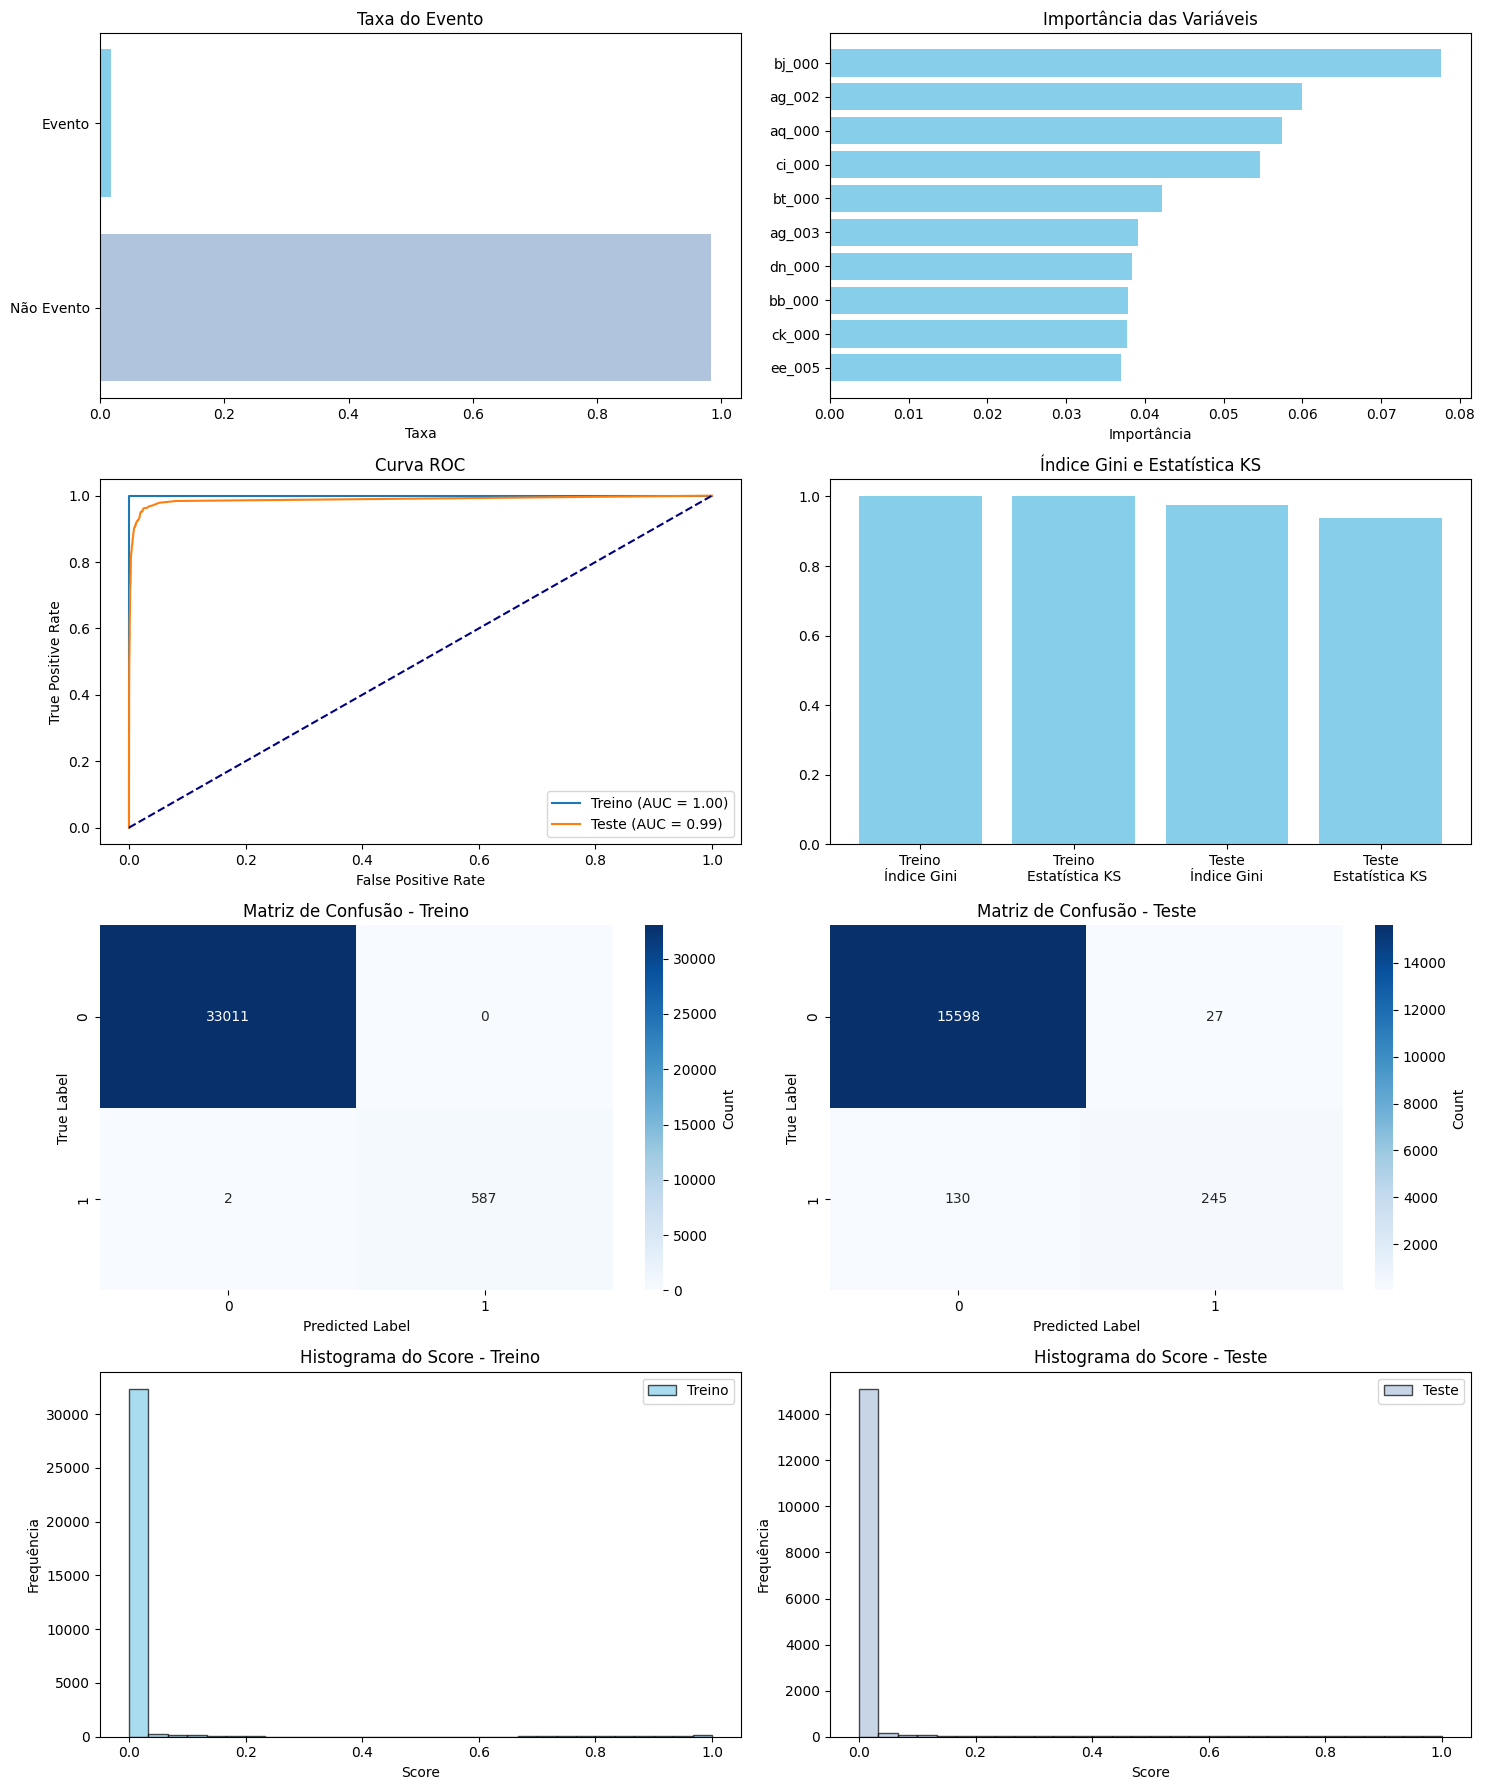

In [9]:
plot_metrics(algoritmo, X_train_processed, y_train, X_prod_processed, y_prod, X_train_processed.columns)

##### Tunning do Modelo Escolhido

In [11]:
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score

# Ignorar todos os warnings
warnings.filterwarnings('ignore')

# Definir o modelo RandomForestClassifier
modelo = RandomForestClassifier(random_state=0)

# Definir parâmetros para o modelo RandomForestClassifier
parametros = {
    'n_estimators': [200, 300],  # Número de árvores na floresta
    'max_depth': [10, 20],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2],  # Número mínimo de amostras em um nó folha
}

# Configurar o scorer para maximizar a precisão
scorer = make_scorer(precision_score, average='binary')

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=modelo, param_grid=parametros, scoring=scorer, refit='precision', cv=5, n_jobs=-1, verbose=2)

# Treinar o modelo
grid_search.fit(X_train_processed, y_train)

# Melhores parâmetros e resultados
print(f"Best parameters found for RandomForestClassifier:")
print(grid_search.best_params_)
print("Best precision score found:", grid_search.best_score_)

# Avaliar modelo com os melhores parâmetros
modelo_final = grid_search.best_estimator_
y_pred = modelo_final.predict(X_test_processed)
test_precision = precision_score(y_test, y_pred)
print(f"Precisão no conjunto de teste: {test_precision}")


# Calcular e exibir métricas
metricas = calculate_metrics('RandomForestClassifier', modelo_final, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found for RandomForestClassifier:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best precision score found: 0.8568947858021293
Precisão no conjunto de teste: 0.813953488372093


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,Teste,0.993214,0.813953,0.630631,0.977539,0.955079,0.917638


In [10]:
algoritmos = [RandomForestClassifier(random_state=0, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200)]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,Teste,0.993214,0.813953,0.630631,0.977539,0.955079,0.917638


##### Verificando desempenho na base de produção

In [11]:
y_prod = df_validation['class']
y_pred = algoritmo.predict(X_prod_processed)

# Calcular precisão e recall
test_precision = precision_score(y_prod, y_pred)
test_recall = recall_score(y_prod, y_pred)

# Exibir resultados
print(f"Precisão no conjunto de produção: {test_precision}")
print(f"Recall no conjunto de produção: {test_recall}")

Precisão no conjunto de produção: 0.9135338345864662
Recall no conjunto de produção: 0.648


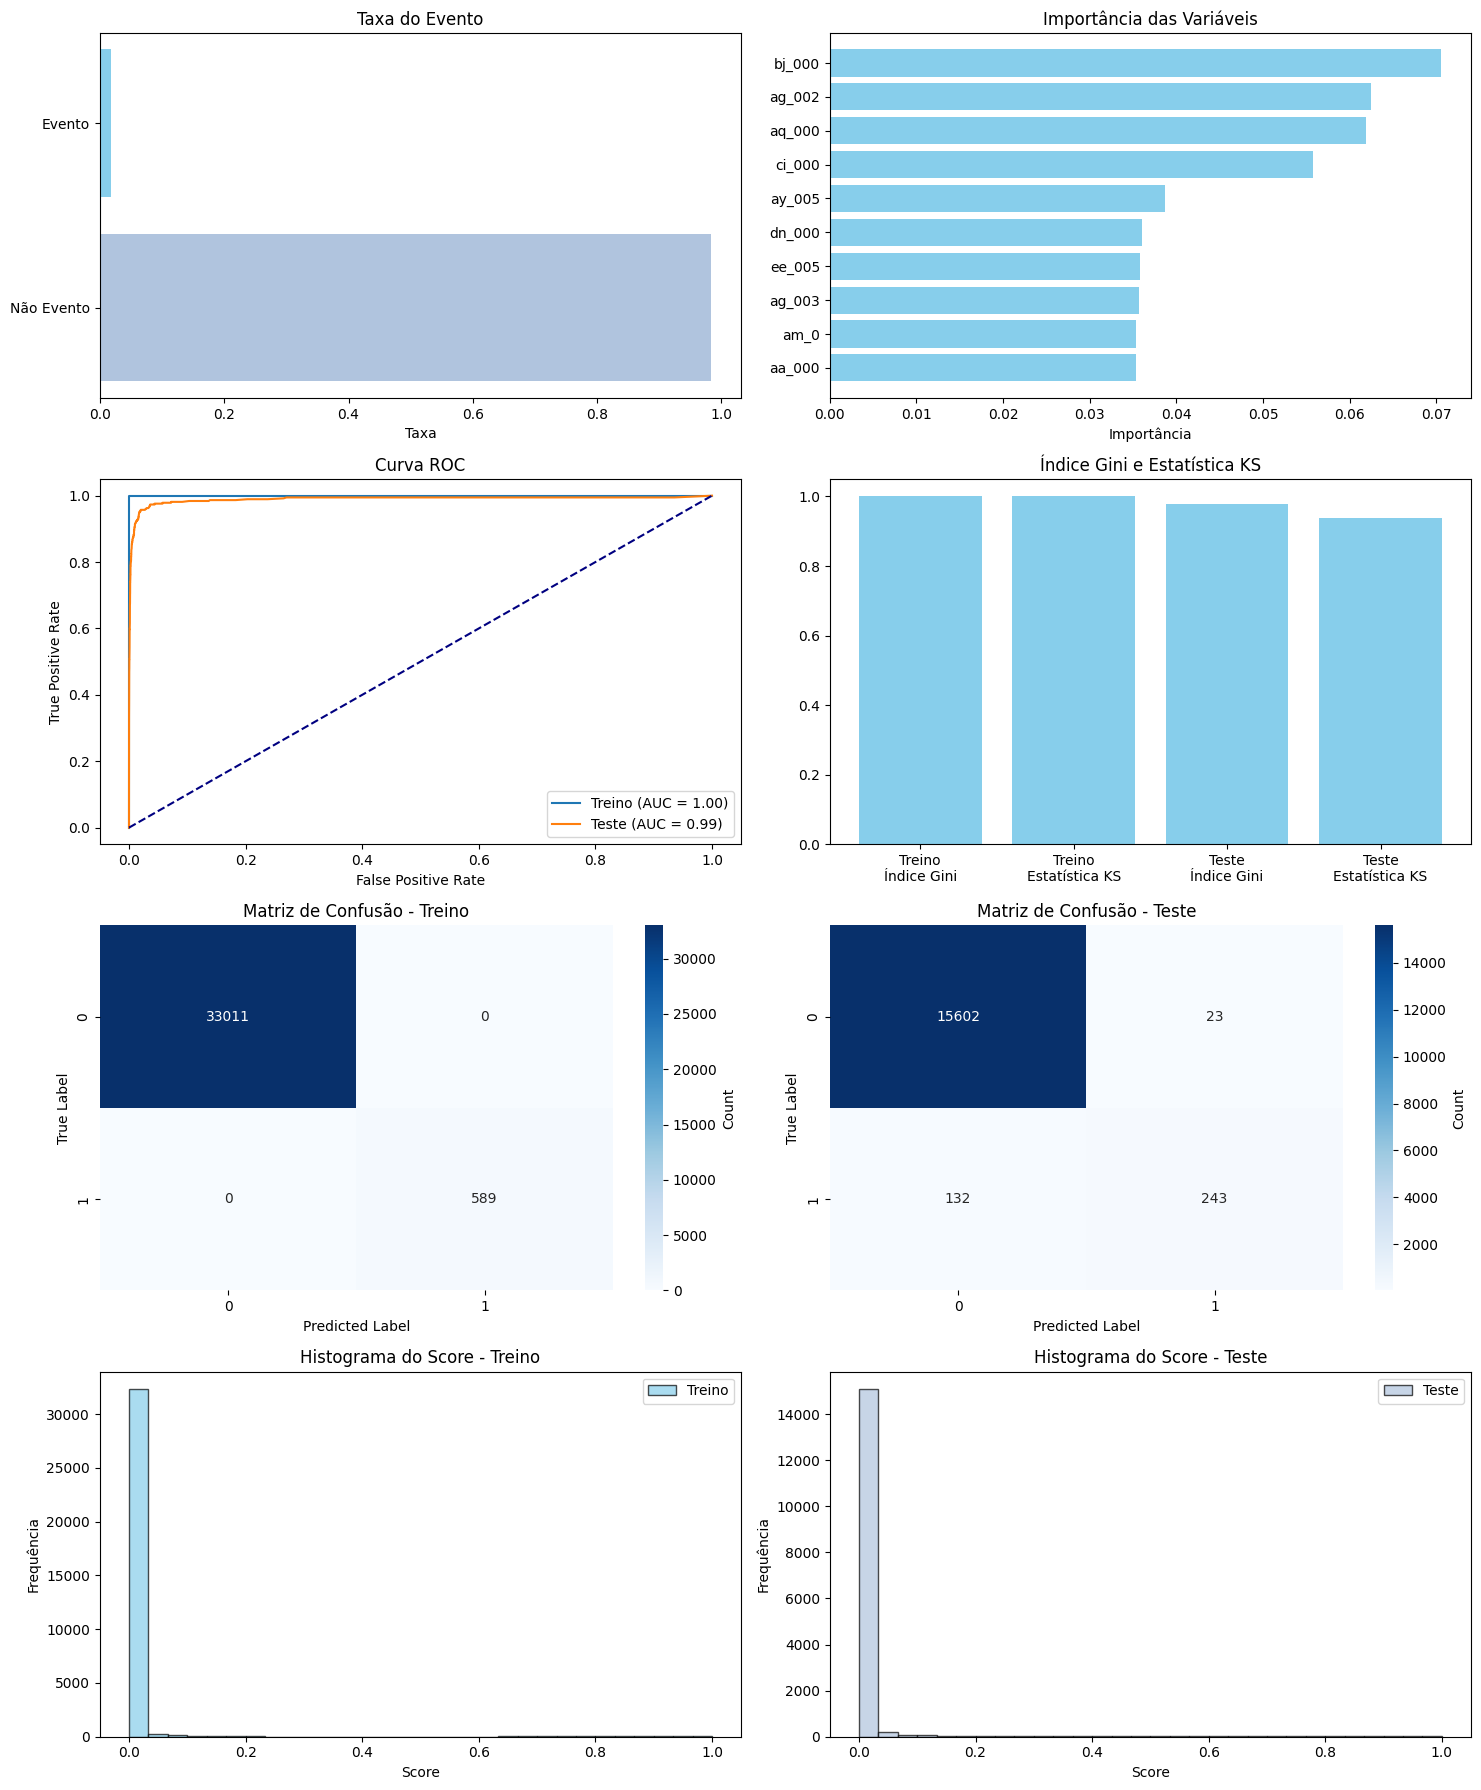

In [12]:
plot_metrics(algoritmo, X_train_processed, y_train, X_prod_processed, y_prod, X_train_processed.columns)

##### Modelo Campeão

Analisando as métricas apresentadas, optaremos pelo primeiro modelo RandomForest como modelo inicial, pois ele consegue prever um pouco melhor os verdadeiros positivos.
